Example of the process of doing DEMs for all orbits for a given observation of an AR – where we don't window out any intervals because of shifts, etc. Instead, we will save energy-specific information about the percent of NuSTAR emission in the chosen region as a function of time, for later inspection. This will help identify cases where pointing shifts might cause unphysical distortion to the DEM inputs. 

Note: auto-download of an AIA file (for use in the initial co-alignmnet) will break while the JSOC is still down. We will add a thing where you can point to an existing AIA file instead.

Overview:

- Define orbits
- Run time interval selection
- Examine resulting intervals
- Manually establish a co-alignment shift between NuSTAR and AIA
- Automatically find co-alignment shifts + make regions for all other time intervals (note: this relies on the assumption that the COM is a good representation of the location of the brightest source, i.e. that the NuSTAR data is primarially one blob).
- Save AIA region files for NCCS input
- NOT IN THIS NOTEBOOK: YOU THEN TAKE THOSE AND MAKE AIA INPUTS ON THE NCCS
- Conduct AIA/NuSTAR DEMs as a function of time, given all the above
- Plot results.
- Print some stats about "left out" times.

In [1]:
# import matplotlib.pyplot as plt
# import numpy as np
# import glob
# from astropy.io import fits
# from astropy import units as u
# import importlib
# import pathlib

#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

# #import nustar_dem_prep as nu
import initial_analysis as ia
import orbit_auto as oa
import time_interval_selection as tis
import nustar_utilities as nuutil
import gauss2D as g2d
import all_nu_analysis as ana


# import os
# # For macOS
# def play_sound():
#     os.system("afplay /System/Library/Sounds/Glass.aiff")

import pickle
import pathlib
import importlib


In [2]:
key = '20-jul-21'


In [3]:
with open('all_targets.pickle', 'rb') as f:
    data = pickle.load(f)

ARDict = data[key]

id_dirs = ARDict['datapaths']
obsids = ARDict['obsids']
working_dir = ARDict['working_dir']


In [4]:
ARDict

{'NOAA_ARID': ['AR12849'],
 'datapaths': ['/Users/jmdunca2/nustar/jul-2021/80710201001/',
  '/Users/jmdunca2/nustar/jul-2021/80710202001/',
  '/Users/jmdunca2/nustar/jul-2021/80710203001/',
  '/Users/jmdunca2/nustar/jul-2021/80710204001/',
  '/Users/jmdunca2/nustar/jul-2021/80710205001/',
  '/Users/jmdunca2/nustar/jul-2021/80710206001/',
  '/Users/jmdunca2/nustar/jul-2021/80710207001/',
  '/Users/jmdunca2/nustar/jul-2021/80710208001/',
  '/Users/jmdunca2/nustar/jul-2021/80710209001/'],
 'obsids': ['80710201001',
  '80710202001',
  '80710203001',
  '80710204001',
  '80710205001',
  '80710206001',
  '80710207001',
  '80710208001',
  '80710209001'],
 'working_dir': '/Users/jmdunca2/do-dem/initial_dem_20jul21/',
 'goes_satellite': 16,
 'orbit durations': [<Quantity 52.81666667 min>,
  <Quantity 9.3 min>,
  <Quantity 60.66666667 min>,
  <Quantity 60.66666667 min>,
  <Quantity 60.66666667 min>,
  <Quantity 60.68333333 min>,
  <Quantity 60.68333333 min>,
  <Quantity 60.68333333 min>,
  <Quant

In [5]:
for id in id_dirs:
    evt_data, hdr = ia.return_submap(datapath=id, fpm='A', return_evt_hdr=True)
    time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
    timerange = [time0, time1]
    print(timerange[0].strftime('%H-%M-%S'), timerange[1].strftime('%H-%M-%S'))

00-24-01 01-16-50
02-52-00 03-01-18
03-37-16 04-37-56
05-13-54 06-14-34
06-50-32 07-51-12
08-27-09 09-27-50
10-03-47 11-04-28
11-40-25 12-41-06
13-17-03 14-17-44


In [6]:
# importlib.reload(ana)

# regions = [{'centerx': -1125,
#           'centery': -183,
#           'radius': 150},
#            {'centerx': -990,
#           'centery': -441,
#           'radius': 150}]
           

# ana.double_gauss_prep(key, plot=True, guess=[160,260], guess2=[], sep_axis='SN', plotregion=regions, 
#                       plotgaussregions=True, write_regions=True, region_dir=working_dir)

In [7]:
# with open('all_targets.pickle', 'rb') as f:
#     data = pickle.load(f)

# ARDict = data[key]

# id_dirs = ARDict['datapaths']
# obsids = ARDict['obsids']
# working_dir = ARDict['working_dir']


In [8]:
# importlib.reload(tis)
# all_targets=data
# index=0
# tis.one_orbit_tis_wrapper(key, all_targets, index, method='doublegauss', use_set_regionfiles=True)

Issue: even when the full-orbit double-gauss fitting does fine, and with a factor added to force a longer interval for the fainter of the two sources, the fitting often fails for sub intervals. In other words, it's possible that a statistically relevant number of counts can be accumulated from a source in a time period shorter than what is needed for that same source to be well-fit in the prescence of a brighter one. 

It is likely necessary to employ a new type of fixed-region method for cases with multiple sources. That's probably what we need for the even weirder sources too (manual entry). So let's see how they react to the double-gauss initial orbit-long fitting to see what all should be able to be incorporated into that model. 

In [9]:
problem_kids = ['01-sep-15', #0 - elongated along limb. REGCOMPARE
                '02-sep-15', #1 - three-source (sometimes), elongated blur otherwise. REGCOMPARE
                '19-feb-16', #2 - single source, not enough counts > 6 keV
                '22-apr-16_1', #3 - single source, not enough counts > 6 keV
                '22-apr-16_2', #4 - single source in chip gap, does not appear in AIA94 (too high altitude?)
                '26-jul-16_1', #5 - Multiple limb sources. Farthest south dominates in orbits 1, 3, 4, but not really in 2. MANUAL REGIONS
                '11-sep-17', #6 - Blobby close-together 2-source. REGCOMPARE
                '12-sep-17', #7 - One source with very faint companion. MANUAL REGIONS
                '13-sep-17', #8 - One source with very faint companion. MANUAL REGIONS
                '10-oct-17', #9 - One source with very faint companion. MANUAL REGIONS
                '29-may-18_2', #10 - Two ARs, one does not appear in AIA94 (too high altitude?)
                '08-jan-21', #11 - Blob. REGCOMPARE
                '07-may-21' #12 - Single source; missing data for one of two orbits. 
               ]



In [10]:


#reasonable regions clearly possible, need new preset-region method (doubles and others). 
manual_regions = ['01-sep-15',
                  '02-sep-15', #1 - three-source (sometimes), elongated blur otherwise.
                  '26-jul-16_1', #5 - Multiple limb sources. Farthest south dominates in orbits 1, 3, 4, but not really in 2. MANUAL REGIONS
                 ]

#regions where we have a plan
planned_process = [#'01-sep-15', #0 - elongated along limb. REGCOMPARE
                   '11-sep-17', #7 - Blobby close-together 2-source. REGCOMPARE
                    '12-sep-17', #8 - One source with very faint companion. MANUAL REGIONS
                    '13-sep-17', #9 - One source with very faint companion. MANUAL REGIONS
                    '10-oct-17',  #10 - One source with very faint companion. MANUAL REGIONS
                  #'08-jan-21', #14 - Blob. REGCOMPARE
                   '20-jul-21', #18 - Double source; MANUAL REGIONS
                    '30-jul-21_1' #19 - Double source; MANUAL REGIONS
                 ]

999.135 arcsec -235.344 arcsec

980.037 arcsec -285.94 arcsec

Percent of data in region 0:  0.5891637693158371
995.008 arcsec -211.883 arcsec

969.951 arcsec -306.717 arcsec

Percent of data in region 0:  0.5865036309953285

976.844 arcsec -311.899 arcsec

1015.87 arcsec -157.828 arcsec

Percent of data in region 0:  0.4358929125972077
996.641 arcsec -127.578 arcsec

972.547 arcsec -316.362 arcsec

Percent of data in region 0:  0.4311181651053423

1038.97 arcsec -155.75 arcsec

986.344 arcsec -301.6 arcsec

Percent of data in region 0:  0.4765614426436945
1017.1 arcsec -152.284 arcsec

977.556 arcsec -314.443 arcsec

Percent of data in region 0:  0.4748924369988136



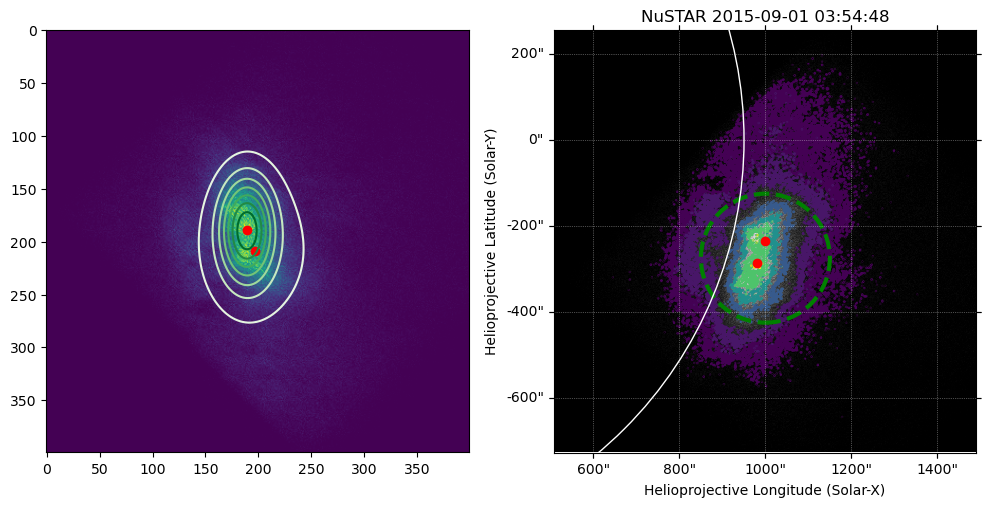

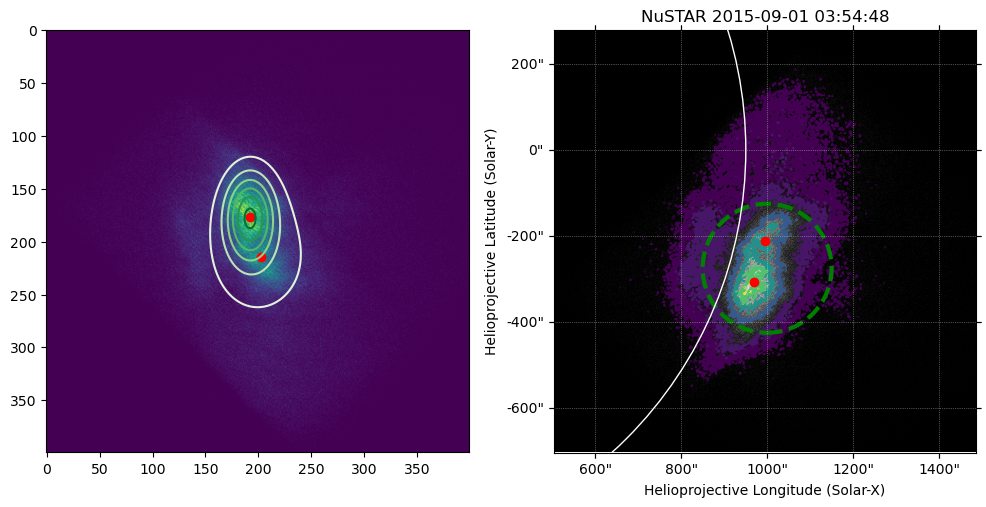

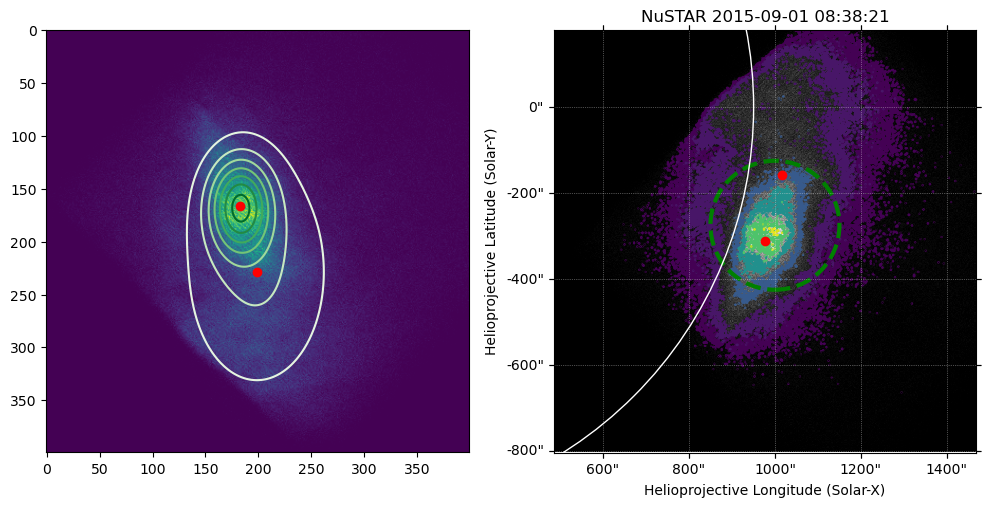

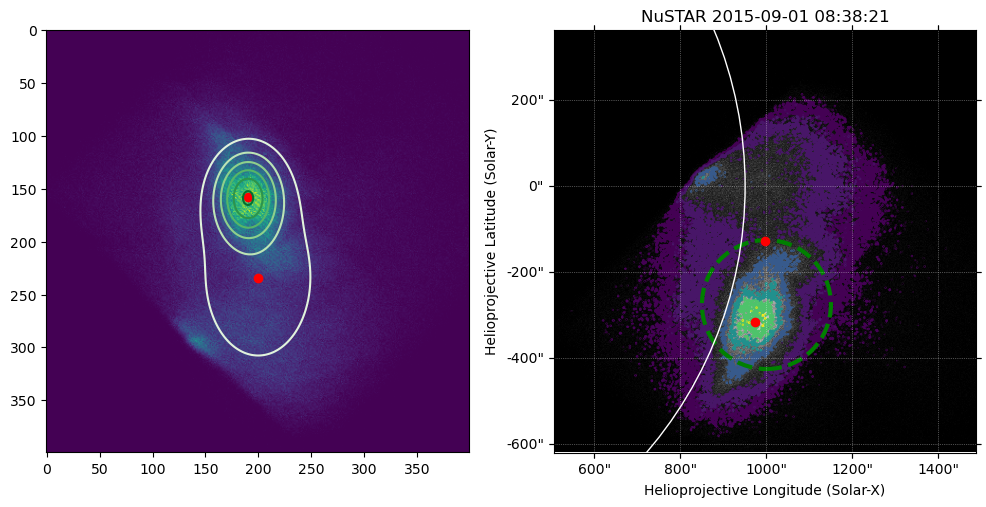

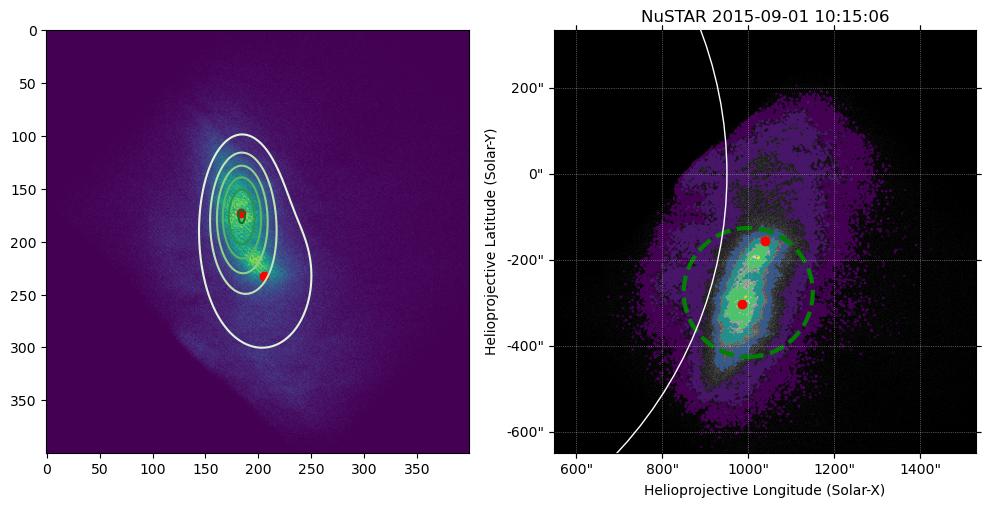

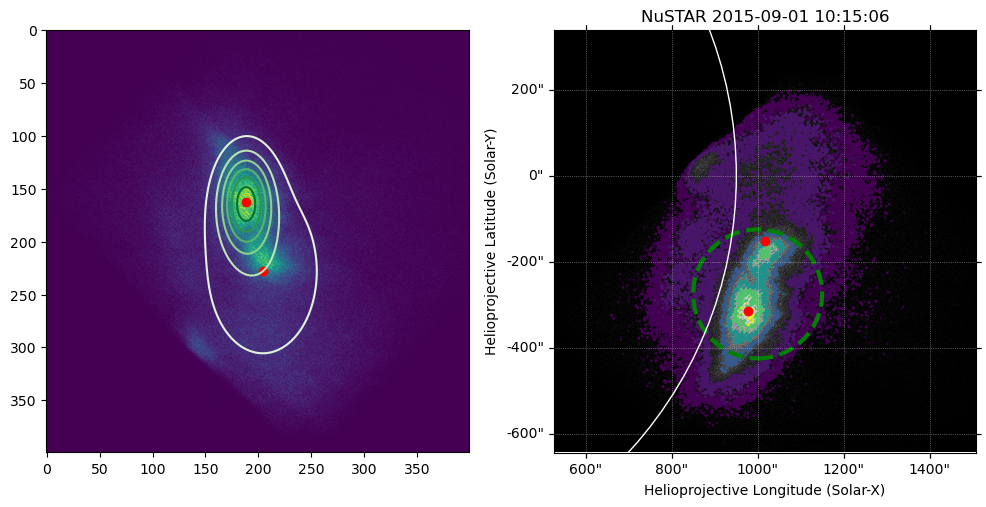

In [24]:
importlib.reload(ana)

#key=manual_regions[0]
#print(key)


key='01-sep-15'

#September 12 2017
#regions = [{'centerx': 900, 'centery': -325, 'radius': 150},
#           {'centerx': 975, 'centery': -50, 'radius': 150}
#          ]

#September 13 2017
#regions = [{'centerx': 940, 'centery': -325, 'radius': 150},
#            {'centerx': 1015, 'centery': -50, 'radius': 150}
#           ]


#October 10 2017
#regions = [{'centerx': 950, 'centery': 330, 'radius': 150},
#            {'centerx': 1000, 'centery': 50, 'radius': 150}
#           ]

#September 1 2015
regions = [{'centerx': 1000, 'centery': -275, 'radius': 150}
          ]

#September 2 2015
#regions = [{'centerx': 1000, 'centery': -280, 'radius': 150}#,
           #{'centerx': 1100, 'centery': 50, 'radius': 150}
#          ]

#NOT DONE YET!

ana.manual_prep(key, plot=True, #guess=[150,200], guess2=[250,250], 
                    #make_scripts=True,
                      #plotgaussregions=True, 
                      plotregion=regions, write_input_regions=True)

#ana.single_gauss_prep(key, plot=True, make_scripts=False, 
#                      plotgaussregions=True)

1022.88 arcsec -73.6781 arcsec

Percent of data in region:  0.7896764663513386
1033.76 arcsec -77.6933 arcsec

Percent of data in region:  0.7674081384634303
1028.74 arcsec -96.865 arcsec

Percent of data in region:  0.7512673017669679
1040.69 arcsec -101.906 arcsec

Percent of data in region:  0.7172408424966443
1024.68 arcsec -108.182 arcsec

Percent of data in region:  0.7128081433391121
1037.67 arcsec -113.971 arcsec

Percent of data in region:  0.6691476018706672
990.314 arcsec -86.4294 arcsec

Percent of data in region:  0.7122456282297192
1000.28 arcsec -90.7897 arcsec

Percent of data in region:  0.6735995101781651


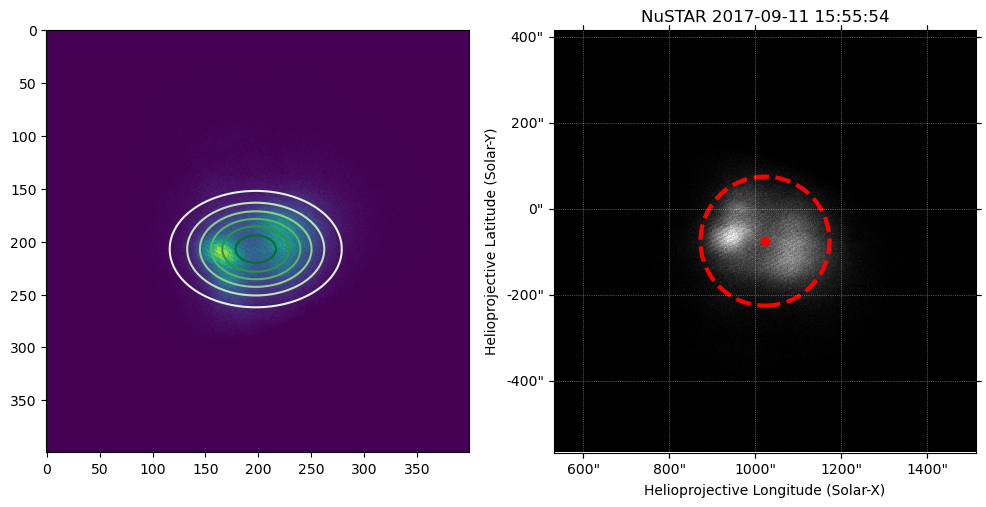

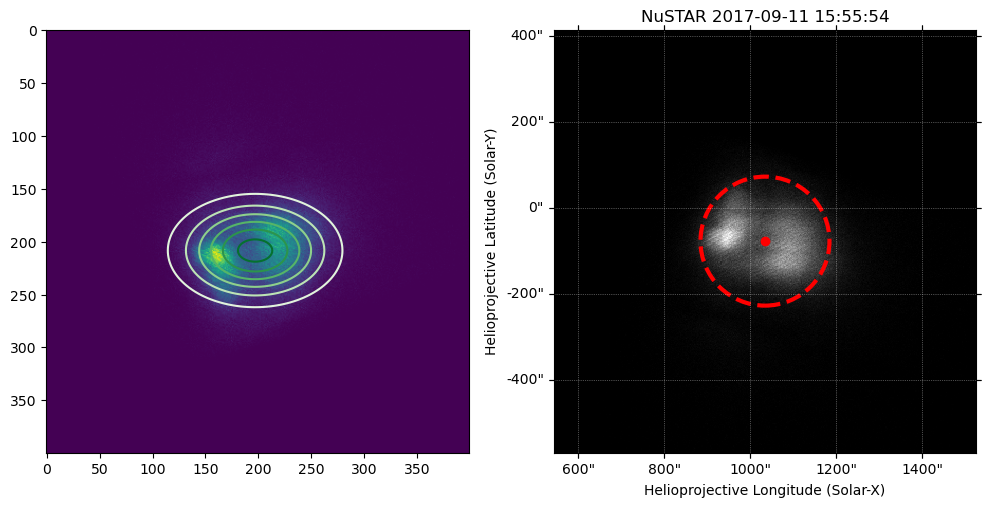

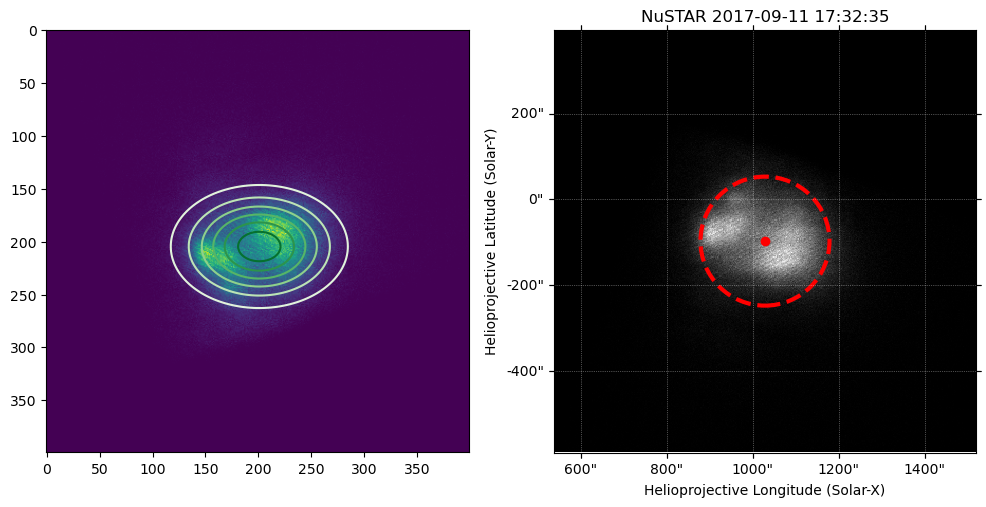

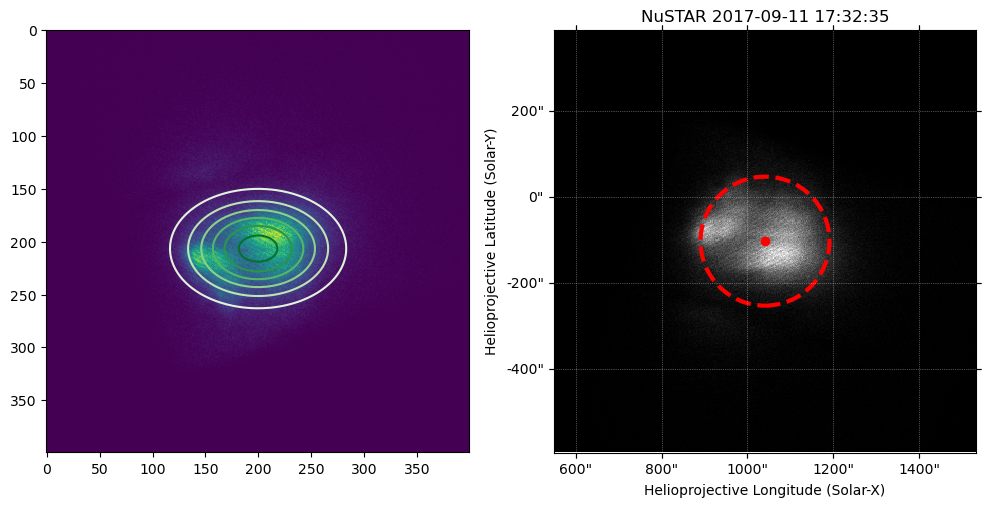

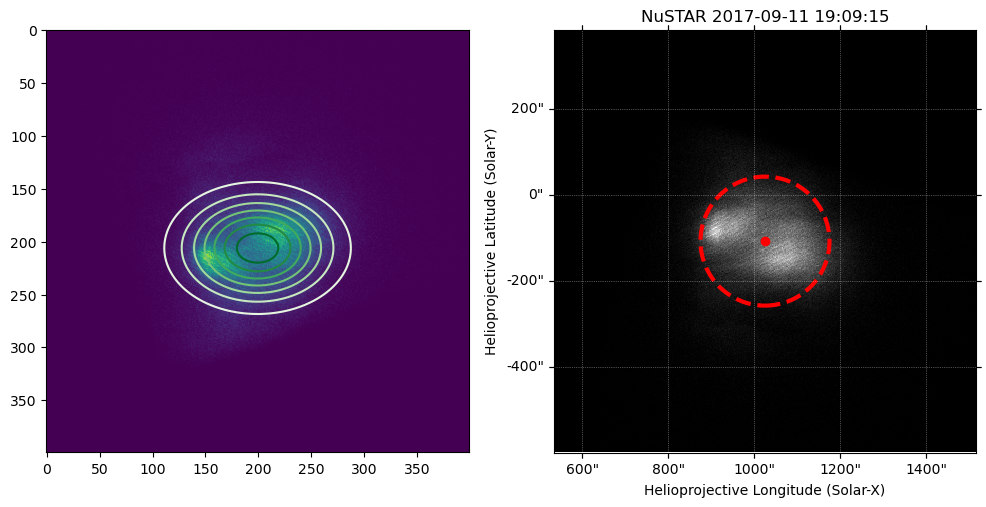

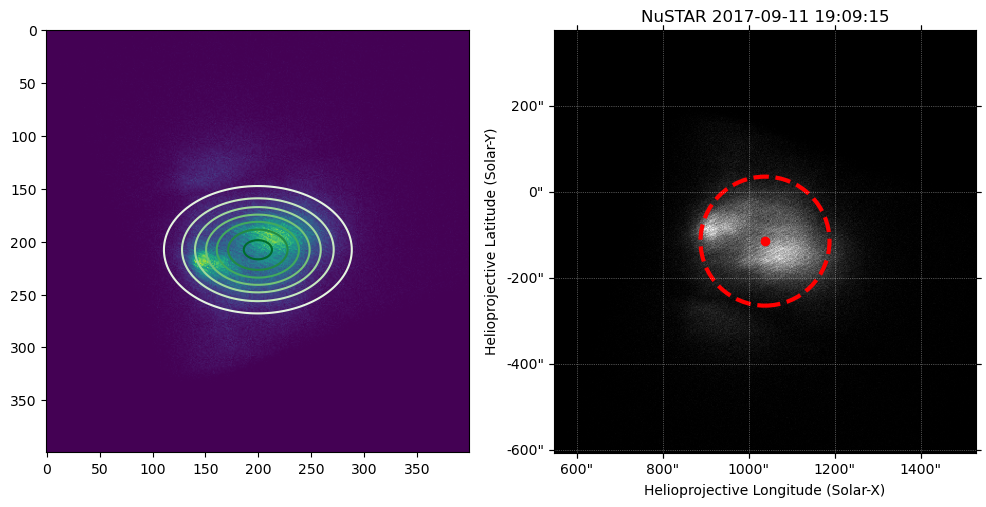

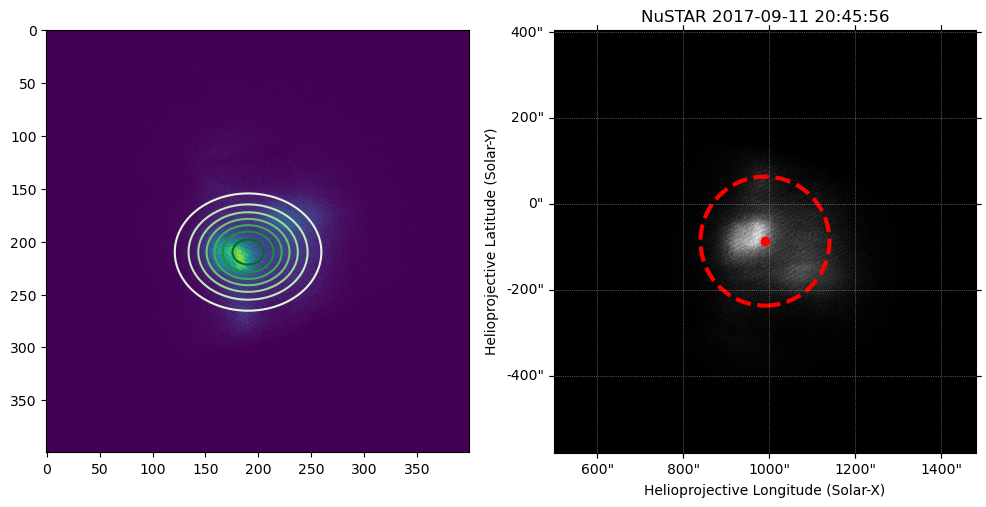

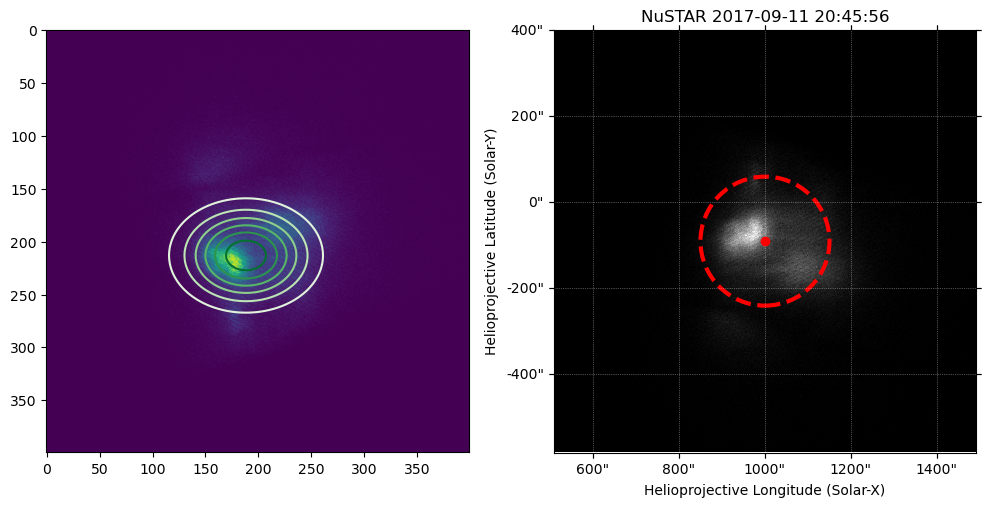

In [31]:
key='11-sep-17'
ana.single_gauss_prep(key, plot=True, make_scripts=False, 
                      plotgaussregions=True)

In [17]:
data.keys()

dict_keys(['01-sep-15', '02-sep-15', '19-feb-16', '22-apr-16_1', '22-apr-16_2', '26-jul-16_1', '26-jul-16_2', '11-sep-17', '12-sep-17', '13-sep-17', '10-oct-17', '29-may-18_1', '29-may-18_2', '09-sep-18', '10-sep-18', '12-apr-19', '13-apr-19', '29-jan-20', '30-jan-20', '06-jun-20', '07-jun-20', '08-jun-20', '09-jun-20', '08-jan-21', '20-jan-21', '29-apr-21', '03-may-21_1', '03-may-21_2', '07-may-21', '20-jul-21_1', '20-jul-21_2', '30-jul-21_1', '30-jul-21_2'])

Using time limits:
[datetime.datetime(2021, 7, 30, 19, 42, 49, 184000, tzinfo=datetime.timezone.utc), datetime.datetime(2021, 7, 30, 20, 43, 22, 184000, tzinfo=datetime.timezone.utc)]


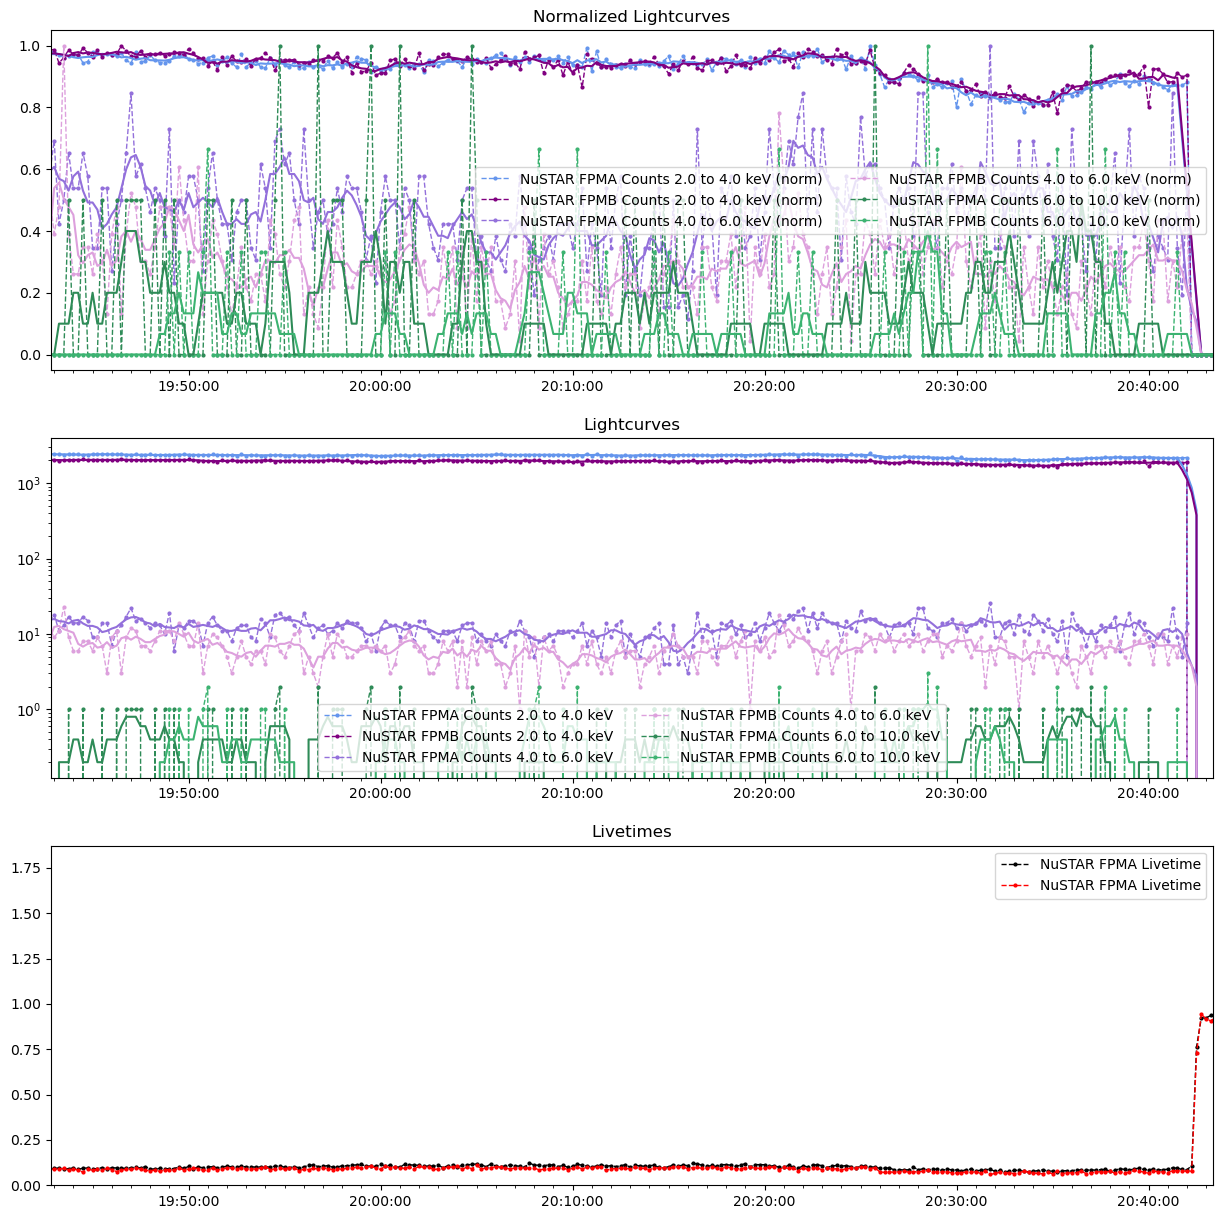

In [7]:
# import glob

# #Set path to obsid directory - initial pipeline should have been run already.
# ind=0
# datapath=id_dirs[ind]
# obsid=obsids[ind]

# evt_data, hdr = ia.return_submap(datapath=datapath, fpm='A', return_evt_hdr=True)
# time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
# timerange = [time0.tt.datetime, time1.tt.datetime]
# from datetime import timezone
# timerange = [t.replace(tzinfo=timezone.utc) for t in timerange]

# #Comment second line if you're not using this same example nustar orbit
# #Edit it to include only the desired time interval (default- all times in file) once you've run this once
# #timerange=[]
# #timerange=[datetime.datetime(2018, 5, 29, 22, 22), datetime.datetime(2018, 5, 29, 23, 20)]

# evtA = glob.glob(datapath+'/event_cl/*A06_cl.evt')
# evtB = glob.glob(datapath+'/event_cl/*B06_cl.evt')
# hkA  = glob.glob(datapath+'/hk/*A_fpm.hk')
# hkB  = glob.glob(datapath+'/hk/*B_fpm.hk')

# import lightcurves as lc

# importlib.reload(lc)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[2.,4.], 
#                               livetime_corr=False, save_dir=working_dir)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[4.,6.], 
#                               livetime_corr=False, save_dir=working_dir)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[6.,10.], 
#                               livetime_corr=False, save_dir=working_dir)

# lc.plot_nustar_lightcurves(eranges = [[2.,4.],[4.,6.],[6.,10.]],
#                            timerange=timerange, save_dir=working_dir)